In [1]:
import json
import web3
import ipdb
import os

#from web3 import Web3
from web3 import Web3, HTTPProvider
from solc import compile_source
from web3.contract import ConciseContract

import pandas as pd
import time
import random

import numpy as np

data = pd.read_csv("Llaves.csv") 

public_keys = data['Llave Publica']
private_keys = data['Llave Privada']

w3 = Web3(HTTPProvider("https://rinkeby.infura.io/v3/4c0ec7f1412a489d91e1934c66ebf5b1"))

## Smart Contracts

In [2]:
## Coops

Coops_abi = open("./abi/Coops.json", "r")
c_values = json.load(Coops_abi)
Coops_abi.close()
coops = w3.eth.contract(
    address = '0x2c66b176962911D2ce40f5809cD52C73c8E78356',
    abi = c_values,
)

## Propietarios

Propietarios_abi = open("./abi/Propietarios.json", "r")
o_values = json.load(Propietarios_abi)
Propietarios_abi.close()
propietarios = w3.eth.contract(
    address = '0xD5fbF619121824aCB4e7aAf66A1d86947CE87f1B',
    abi = o_values,
)

## Proveedores

Proveedores_abi = open("./abi/Proveedores.json", "r")
v_values = json.load(Proveedores_abi)
Proveedores_abi.close()
proveedores = w3.eth.contract(
    address = '0x71eCEF369c041955C9993c635144a629c82CcD86',
    abi = v_values,
)

## Instaladores

Instaladores_abi = open("./abi/Instaladores.json", "r")
i_values = json.load(Instaladores_abi)
Instaladores_abi.close()
instaladores = w3.eth.contract(
    address = '0xC0ed1D311963EFc99418C0C84Ff2661CF199f9b0',
    abi = i_values
)

## Gestores

Gestores_abi = open("./abi/Gestores.json", "r")
m_values = json.load(Gestores_abi)
Gestores_abi.close()
gestores = w3.eth.contract(
    address = '0x23215E9FFaE52Eaf79c861d4F620A9748f3652C1',
    abi = m_values
)

## CF

CF_abi = open("./abi/CF.json", "r")
cf_values = json.load(CF_abi)
CF_abi.close()
cf = w3.eth.contract(
    address = '0x4Bac31B5056b1975D286d552F64F7962b8f2b2cc',
    abi = cf_values
)

## Proyectos

Proyectos_abi = open("./abi/Proyectos.json", "r")
p_values = json.load(Proyectos_abi)
Proyectos_abi.close()
proyectos = w3.eth.contract(
    address = '0x05c24902c594c255E4d2FA9B5D8ca7c1d44A7E85',
    abi = p_values
)

In [3]:
def match(public_keys,private_keys): 
    i_interest_rate = proyectos.call().interest_rate()
    i_demands = propietarios.call().getUserCount()
    for i_demand in range(i_demands):
        address_d = propietarios.call().getUserAtIndex(i_demand)
        b_funding = propietarios.call().getFunding(address_d)
        i_MaxPrice = propietarios.call().getDemand(address_d)
        i_vendors = proveedores.call().getProvidersCount()
        for i_vendor in range(i_vendors):
            address_v = proveedores.call().getProviderAtIndex(i_vendor)
            i_price_v = proveedores.call().getProvider(address_v)
            i_installers = instaladores.call().getInstallersCount()
            for i_installer in range(i_installers):
                address_i = instaladores.call().getInstallerAtIndex(i_installer)
                i_price_i = instaladores.call().getInstaller(address_i)
                i_managers = gestores.call().getManagersCount()
                for i_manager in range(i_managers): 
                    address_m = gestores.call().getManagerAtIndex(i_manager)
                    i_price_m = gestores.call().getManager(address_m)

                    i_projectcost = int((i_price_v + i_price_i + i_price_m)*(100+i_interest_rate)/100)
                    if i_projectcost <= i_MaxPrice:
                        if b_funding == False:
                            print('Project Cost = '+str(i_projectcost))
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = proyectos.functions.Matching(address_d,address_v,
                                                                         address_i,address_m).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)

                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

                            # Wait for the transaction to be mined, and get the transaction receipt
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            return (tx_receipt,b_funding)


                        elif b_funding == True:
                            print(i_projectcost)
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = cf.functions.Crowdsale(address_d,address_v,address_i,
                                                                   address_m,1).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gas': 3000000,
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)
                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            
                            return (tx_receipt,b_funding)
                        
    print('No match found')
    return False
                    


## Caso base 1

In [5]:
b_funding = False
i_MaxPrice = 2000000
i_price_v = 1000000
i_price_i = 100000
i_price_m = 10000

i_txs = 0
gas_used = 0

#===================Demand==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[1])

construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Demand = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed


#===================VENDOR==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[2])

construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================INSTALLER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[3])

construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Installer = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MANAGER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[4])

construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Manager = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MATCHING==========================
xmatch = match(public_keys,private_keys) 
tx_receipt = xmatch[0]
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by Matching = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

print(public_keys[1]+' totaldebt = ' + str(coops.call().getTotalDebt(public_keys[1])))
print(public_keys[1]+' ows to '+public_keys[2]+' '+str(coops.call().getDebt(public_keys[1],public_keys[2]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[3]+' '+str(coops.call().getDebt(public_keys[1],public_keys[3]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[4]+' '+str(coops.call().getDebt(public_keys[1],public_keys[4]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[0]+' '+str(coops.call().getDebt(public_keys[1],public_keys[0]))+' Coops')
print('Total_TX = '+str(i_txs))
print('Total_Gas = '+str(gas_used))

acct = w3.eth.account.privateKeyToAccount(private_keys[1])
for address in public_keys:
    debt = coops.call().getDebt(acct.address,address)
    if debt > 0: 
        construct_txn = coops.functions.Pay(address,debt).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Debt of '+acct.address+' = '+str(coops.call().getTotalDebt(acct.address))+ '  Coops')

0x906aab7f3157e3246f66e088db07c5f2dd0e100ba1c026537858c419923ea8f5
Gas used by New Demand = 23298
0x5ab7ca085dee1ba318142ab1e4750cb9de3a9f4f3ff63c12cc59642d3c6c1861
Gas used by New Vendor = 23064
0xf5f233f88708ace9ee6c88f86822ab51f36c6d7e6d58b5570e30c6b514837fb5
Gas used by New Installer = 22954
0xf1d158a613026199ad0d2d3cea721c51cc55a25c8b371eebd79ebf207e4cc4dc
Gas used by New Manager = 22912
1165500
0x248908016e419909ab47480185bfc0de5ca50317036c34953aef15bf6749287f
Gas used by Matching = 27974
0x6C740120A054cecF209BCaCF62fC38Cc64D98499 totaldebt = 0
0x6C740120A054cecF209BCaCF62fC38Cc64D98499 ows to 0x520597cF4C6f9aed321a39a12529911350c7d0BF 0 Coops
0x6C740120A054cecF209BCaCF62fC38Cc64D98499 ows to 0x6c2a6C2F7B3ABf37575a423E72d91C78F72B36E8 0 Coops
0x6C740120A054cecF209BCaCF62fC38Cc64D98499 ows to 0x29b93fdD9D9BE8c80d483aA94CA12496f09006C8 0 Coops
0x6C740120A054cecF209BCaCF62fC38Cc64D98499 ows to 0xCBE861ab7726f2974289cE6b6aB7AD999D886E2F 0 Coops
Total_TX = 5
Total_Gas = 120202


## Caso base 2

In [5]:
i_MaxPrice = 0
totalCost = 1

b_funding = True
i_MaxPrice = 2000000
i_price_v = 1000000
i_price_i = 100000
i_price_m = 10000

i_txs = 0
gas_used = 0

print('Total Cost = '+str(totalCost))
#===================Demand==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[1])

construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Demand = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed


#===================VENDOR==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[2])

construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================INSTALLER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[3])

construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Installer = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MANAGER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[4])

construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Manager = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MATCHING==========================

xmatch = match(public_keys,private_keys)
if xmatch != False: 
    if xmatch[1] == True:
        tx_receipt = xmatch[0]
        i_txs += 1
        print('Gas used by Matching = '+str(tx_receipt.gasUsed))
        gas_used += tx_receipt.gasUsed
        
print(tx_receipt['blockHash'].hex())

#===================FUNDING==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[5])

fundingGoal = cf.call().fundingGoal()
construct_txn = coops.functions.Fund(cf.address,fundingGoal).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

i_txs += 1
print('Gas used by Fund = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

time.sleep(60)

#===================CHECK(S) & WITHDRAWAL==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[1])

print('Balance of '+acct.address+' = '+str(coops.call().balanceOf(acct.address))+ '  Coops')
#print('Checking...')
while cf.call().crowdsaleClosed() == False:
    construct_txn = cf.functions.checkGoalReached().buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print(tx_receipt['blockHash'].hex())
    i_txs += 1
    print('Gas used by Check = '+str(tx_receipt.gasUsed))
    gas_used += tx_receipt.gasUsed

construct_txn = cf.functions.safeWithdrawal().buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
#print('Balance of '+acct.address+' = '+str(coops.call().balanceOf(acct.address))+ '  Coops')
print('Gas used by Whitdrawal = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed 

print('Total_TX = '+str(i_txs))
print('Total_Gas = '+str(gas_used))

print(public_keys[1]+' totaldebt = ' + str(coops.call().getTotalDebt(public_keys[1])))
print(public_keys[1]+' ows to '+public_keys[2]+' '+str(coops.call().getDebt(public_keys[1],public_keys[2]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[3]+' '+str(coops.call().getDebt(public_keys[1],public_keys[3]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[4]+' '+str(coops.call().getDebt(public_keys[1],public_keys[4]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[0]+' '+str(coops.call().getDebt(public_keys[1],public_keys[0]))+' Coops')

acct = w3.eth.account.privateKeyToAccount(private_keys[1])
for address in public_keys:
    debt = coops.call().getDebt(acct.address,address)
    if debt > 0: 
        construct_txn = coops.functions.Pay(address,debt).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Debt of'+acct.address+' = '+str(coops.call().getTotalDebt(acct.address))+ '  Coops')
        

print('Generate')

j = proyectos.call().numProjects()-1
holder = proyectos.call().getProject(j)[0]
acct = w3.eth.account.privateKeyToAccount(private_keys[public_keys == holder].values[0])
generated = np.sum(np.random.normal(5, 0.4, 30))
construct_txn = coops.functions.Generate(int(generated),j).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gasPrice': w3.toWei('1.4', 'gwei')})
signed = acct.signTransaction(construct_txn)
tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        

Total Cost = 1
0x466619aa0fd9e9749a6c894418956d9204596ef379059d0efc11106c21b05e21
Gas used by New Demand = 70900
0x03cee4dcd13e1b1acf84ce1cfdc277790ba2596bc1ce202f0d40bc1aa5fdf0b4
Gas used by New Vendor = 65081
0xcd6f2116ac99e6dd718f20e06380225de1049c158f6f219c8e7a087da9e10bc7
Gas used by New Installer = 64971
0x6ec17fbb059704de92181addb1a88e430cdcedb967ae32a3f68c576dfd0af06e
Gas used by New Manager = 64929
1165500
Gas used by Matching = 61768
0x16a037028509bf7c3f69bb9d861fdb4df54f2e9cf3979d723eb12238885f7693
Gas used by Fund = 191360
Balance of 0x6C740120A054cecF209BCaCF62fC38Cc64D98499 = 199149380  Coops
0x2291e292e9b06b6c8214fe81b59469a355ac2f3dadbc9d20be4c41cf43c191b8
Gas used by Check = 32093
0x4aad2e4cd4aae3ab53c67d0a2093973057fa18ba206c8e1bbfaaa0a939700d6d
Gas used by Whitdrawal = 437372
Total_TX = 8
Total_Gas = 988474
0x6C740120A054cecF209BCaCF62fC38Cc64D98499 totaldebt = 1165500
0x6C740120A054cecF209BCaCF62fC38Cc64D98499 ows to 0x520597cF4C6f9aed321a39a12529911350c7d0BF 100000

## Simulacion

In [6]:
i_projects = 12
print('Actualmente hay '+str(coops.call().numProjects())+' proyectos')
i_goal = coops.call().numProjects() + i_projects
gas = []
ggas = []
i_check = []
step = 1
steps = 12
balances = np.zeros((len(public_keys),steps+1))
i_ids = [] 
paygas = []

for i in range(len(public_keys)):
     balances[i,0] = coops.call().balanceOf(public_keys[i])
        
while step <= steps:
    print(step)
    #print('Match')
    xmatch = match(public_keys,private_keys)
    if xmatch != False:
        tx_receipt = xmatch[0]
        if xmatch[1] == False:
            gas.append(tx_receipt.gasUsed)

        elif xmatch[1] == True:
            print('CF')
            tx_receipt = xmatch[0]
            gas.append(tx_receipt.gasUsed)
            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
            
            while cf.call().crowdsaleClosed() == False:
                construct_txn = cf.functions.checkGoalReached().buildTransaction({
                    'from': acct.address,
                    'nonce': w3.eth.getTransactionCount(acct.address),
                    'gas': 3000000,
                    'gasPrice': w3.toWei('1', 'gwei')})
                
                signed = acct.signTransaction(construct_txn)
                tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                i_check.append(tx_receipt.gasUsed)
                #gas.append(i_gas + tx_receipt.gasUsed)
                
                while cf.call().beneficiary() != '0x0000000000000000000000000000000000000000':
                    pass
               
        i_ids.append(coops.call().numProjects()-1)
        
    print('Generate')
    for j in i_ids:
        holder = coops.call().getProject(j)[0]
        acct = w3.eth.account.privateKeyToAccount(private_keys[public_keys == holder].values[0])
        generated = np.sum(np.random.normal(5, 0.4, 30))
        construct_txn = coops.functions.Generate(int(generated),j).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        ggas.append(tx_receipt.gasUsed)
        
    print('Payment')
    #for i in range(1,len(public_keys)):
    for i in range(1,25):
        totaldebt = coops.call().getTotalDebt(public_keys[i])
        if totaldebt > 0:
            acct = w3.eth.account.privateKeyToAccount(private_keys[i])
            for address in public_keys:
                debt = coops.call().getDebt(acct.address,address)
                if debt > 0: 
                    construct_txn = coops.functions.Pay(address,debt).buildTransaction({
                        'from': acct.address,
                        'nonce': w3.eth.getTransactionCount(acct.address),
                        'gas': 3000000,
                        'gasPrice': w3.toWei('1.4', 'gwei')})
                    signed = acct.signTransaction(construct_txn)

                    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                    # Wait for the transaction to be mined, and get the transaction receipt
                    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                    paygas.append(tx_receipt.gasUsed)
                    
    for i in range(len(public_keys)):
        balances[i,step] = coops.call().balanceOf(public_keys[i])
    step += 1
    
print('Ahora hay '+str(coops.call().numProjects())+' proyectos')

Actualmente hay 260 proyectos
1
1573635
CF
Generate
Payment
2
Project Cost = 1133337
Generate
Payment
3
Project Cost = 2136065
Generate
Payment
4
Project Cost = 1958360
Generate
Payment
5
1927032
CF
Generate
Payment
6
Project Cost = 1969181
Generate
Payment
7
Project Cost = 2160198
Generate
Payment
8
1492746
CF
Generate
Payment
9
1336830
CF
Generate
Payment
10
Project Cost = 797751
Generate
Payment
11
1505393
CF
Generate
Payment
12
1779107
CF
Generate
Payment
Ahora hay 272 proyectos


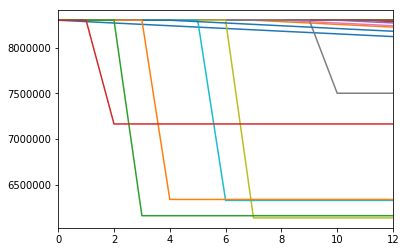

In [290]:
t = np.linspace(0,12,13)
import matplotlib.pyplot as plt
#plt.figure(figsize=(17,12))
#plt.plot(t,balances[1,:])
for i in range(1,25):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

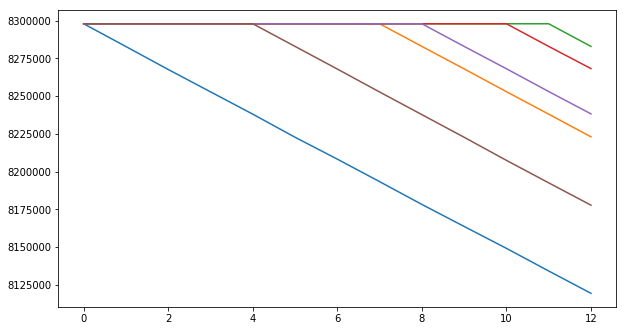

In [340]:
plt.figure(figsize=(10,12))

plt.subplot(211)
plt.plot(t[0:13],balances[1,:])
plt.plot(t[0:13],balances[2,:])
#plt.plot(t[0:13],balances[3,:])
#plt.plot(t[0:13],balances[4,:])
#plt.plot(t[0:13],balances[5,:])
#plt.plot(t[0:13],balances[6,:])

#plt.plot(t[0:13],balances[7,:])
#plt.plot(t[0:13],balances[8,:])
#plt.plot(t[0:13],balances[9,:])
#plt.plot(t[0:13],balances[10,:])
#plt.plot(t[0:13],balances[11,:])
#plt.plot(t[0:13],balances[12,:])


#plt.plot(t[0:13],balances[13,:])
plt.plot(t[0:13],balances[14,:])
plt.plot(t[0:13],balances[15,:])
#plt.plot(t[0:13],balances[16,:])
plt.plot(t[0:13],balances[17,:])
#plt.plot(t[0:13],balances[18,:])

#plt.plot(t[0:13],balances[19,:])
#plt.plot(t[0:13],balances[20,:])
plt.plot(t[0:13],balances[21,:])
#plt.plot(t[0:13],balances[22,:])
#plt.plot(t[0:13],balances[23,:])
#plt.plot(t[0:13],balances[24,:])

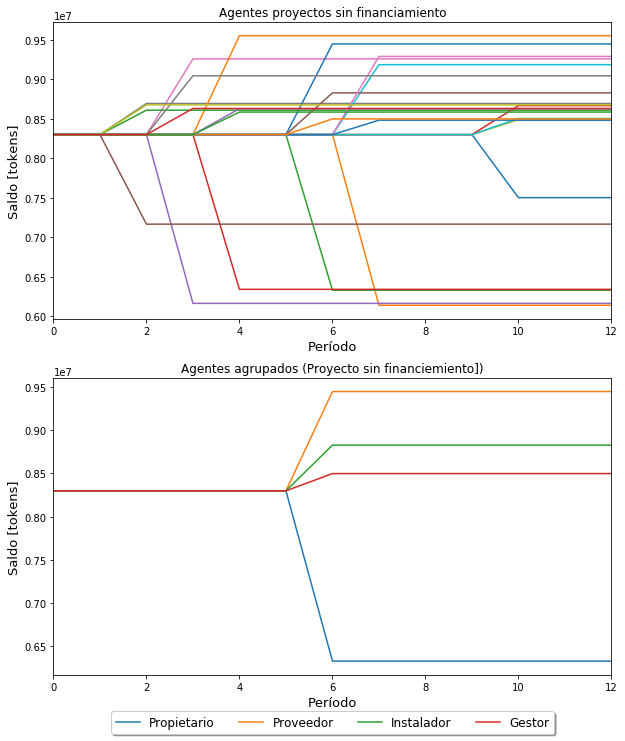

In [410]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,12))

plt.subplot(211)
plt.plot(t[0:13],balances[18,:])
plt.plot(t[0:13],balances[19,:])
plt.plot(t[0:13],balances[20,:])
plt.plot(t[0:13],balances[22,:])
plt.plot(t[0:13],balances[23,:])
plt.plot(t[0:13],balances[24,:])

plt.plot(t[0:13],balances[25,:])
plt.plot(t[0:13],balances[28,:])
plt.plot(t[0:13],balances[32,:])
plt.plot(t[0:13],balances[39,:])
plt.plot(t[0:13],balances[42,:])
plt.plot(t[0:13],balances[44,:])

plt.plot(t[0:13],balances[46,:])
plt.plot(t[0:13],balances[48,:])
plt.plot(t[0:13],balances[54,:])
plt.plot(t[0:13],balances[60,:])
plt.plot(t[0:13],balances[62,:])
plt.plot(t[0:13],balances[63,:])

plt.plot(t[0:13],balances[65,:])
plt.plot(t[0:13],balances[67,:])
plt.plot(t[0:13],balances[68,:])
plt.plot(t[0:13],balances[80,:])
plt.plot(t[0:13],balances[82,:])
plt.plot(t[0:13],balances[83,:])
plt.xlabel('Período', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
plt.margins(x=0)
plt.title("Agentes proyectos sin financiamiento")

plt.subplot(212)
plt.plot(t[0:13],balances[20,:],label='Propietario')
plt.plot(t[0:13],balances[42,:],label='Proveedor')
plt.plot(t[0:13],balances[60,:],label='Instalador')
plt.plot(t[0:13],balances[80,:],label='Gestor')
plt.xlabel('Período', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
plt.title("Agentes agrupados (Proyecto sin financiemiento])")
plt.margins(x=0)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22),
          fancybox=True, shadow=True, ncol=5, fontsize=12)

In [409]:
balances[83,:]

array([8297890., 8297890., 8297890., 8628716., 8628716., 8628716.,
       8628716., 8628716., 8628716., 8628716., 8628716., 8628716.,
       8628716.])

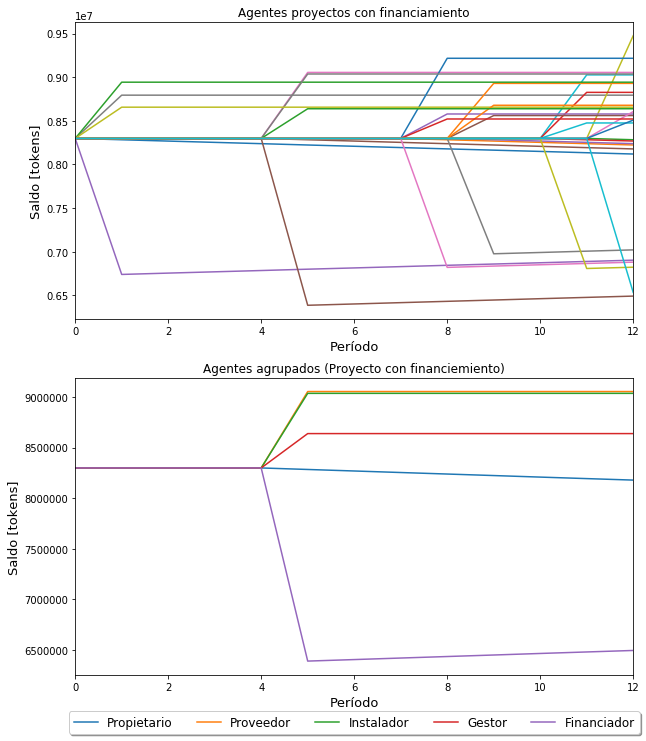

In [413]:
plt.figure(figsize=(10,12))

plt.subplot(211)
plt.plot(t[0:13],balances[1,:])
plt.plot(t[0:13],balances[2,:])
plt.plot(t[0:13],balances[14,:])
plt.plot(t[0:13],balances[15,:])
plt.plot(t[0:13],balances[17,:])
plt.plot(t[0:13],balances[21,:])


plt.plot(t[0:13],balances[26,:])
plt.plot(t[0:13],balances[27,:])
plt.plot(t[0:13],balances[34,:])
plt.plot(t[0:13],balances[37,:])
plt.plot(t[0:13],balances[38,:])
plt.plot(t[0:13],balances[41,:])


plt.plot(t[0:13],balances[45,:])
plt.plot(t[0:13],balances[57,:])
plt.plot(t[0:13],balances[58,:])
plt.plot(t[0:13],balances[59,:])
plt.plot(t[0:13],balances[61,:])
plt.plot(t[0:13],balances[64,:])

plt.plot(t[0:13],balances[66,:])
plt.plot(t[0:13],balances[71,:])
plt.plot(t[0:13],balances[76,:])
plt.plot(t[0:13],balances[79,:])
plt.plot(t[0:13],balances[81,:])
plt.plot(t[0:13],balances[84,:])

plt.plot(t[0:13],balances[85,:])
plt.plot(t[0:13],balances[86,:])
plt.plot(t[0:13],balances[87,:])
plt.plot(t[0:13],balances[88,:])
plt.plot(t[0:13],balances[89,:])
plt.plot(t[0:13],balances[90,:])

plt.xlabel('Período', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
plt.margins(x=0)
plt.title("Agentes proyectos con financiamiento")

plt.subplot(212)
plt.plot(t[0:13],balances[21,:],label='Propietario')
plt.plot(t[0:13],balances[26,:],label='Proveedor')
plt.plot(t[0:13],balances[64,:],label='Instalador')
plt.plot(t[0:13],balances[81,:],label='Gestor')
plt.plot(t[0:13],balances[86,:],label='Financiador')
plt.xlabel('Período', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
plt.title("Agentes agrupados (Proyecto con financiemiento)")
plt.margins(x=0)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22),
          fancybox=True, shadow=True, ncol=5, fontsize=12)

In [ ]:

import matplotlib.pyplot as plt
plt.plot(t,balances[17,:],label=str(17))
#for i in range(17,25):
 #   plt.plot(t[0:13],balances[i,:],label=str(i))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=4, fontsize=13)    
plt.margins(x=0)

In [ ]:

import matplotlib.pyplot as plt
#plt.plot(t,balances[29,:])
for i in range(25,33):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [ ]:

import matplotlib.pyplot as plt
#plt.plot(t,balances[33,:])
for i in range(33,41):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [ ]:
gas

In [ ]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5,6,7],gas)
plt.xlabel('Proyecto', fontsize=13)
plt.ylabel('Costo [gas]', fontsize=13)

In [ ]:
t = np.linspace(0,18,19)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[6,0:12],label='Propietario')
plt.plot(t[0:12],balances[14,0:12],label='Proveedor')
plt.plot(t[0:12],balances[22,0:12],label='Instalador')
plt.plot(t[0:12],balances[30,0:12],label='Gestor')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=4, fontsize=13)

In [ ]:


t = np.linspace(0,18,19)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[1,0:12],label='Propietario')
plt.plot(t[0:12],balances[9,0:12],label='Proveedor')
plt.plot(t[0:12],balances[20,0:12],label='Instalador')
plt.plot(t[0:12],balances[29,0:12],label='Gestor')
plt.plot(t[0:12],balances[33,0:12],label='Financiador')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=5, fontsize=13)

In [ ]:
public_keys.duplicated()

NameError: name 'np' is not defined